## Prueba de implementación de PoinNet

Este _notebook_ está dedicado a probar una **implementación de PointNet con Tensorflow 2.0 y Keras**. Se utilizará un subconjunto de validación del **GOOSE dataset** para entrenar el modelo. Este consta de **151 nubes de puntos** de una dimensión variable. Se realizará un estudio estadístico de las clases contenidas en estas 151 nubes de puntos para evaluar si es necesario completar con más nubes de puntos que contengan las clases faltantes.

### Importaciones

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import re
import matplotlib.pyplot as plt
import random as rand


from pathlib import Path
from sklearn.model_selection import train_test_split

2024-12-20 09:19:07.443991: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 09:19:07.447224: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 09:19:07.456499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734682747.472292   17819 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734682747.476779   17819 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 09:19:07.493543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Carga del GOOSE Dataset

In [4]:
# Windows

# point_clouds_path = Path(r"goose\val\2022-07-22_flight")
# labels_path = Path(r"goose\labels\val\2022-07-22_flight")

# Linux

point_clouds_path = Path(r"/home/felix/Escritorio/TFG/datasets/Goose/goose_3d_val/lidar/val/2022-07-22_flight")
labels_path = Path(r"/home/felix/Escritorio/TFG/datasets/Goose/goose_3d_val/labels/val/2022-07-22_flight")

Se ordenan los archivos para establecer un orden entre nubes de puntos y etiquetas

In [5]:
files_list = os.listdir(point_clouds_path)
labels_list = os.listdir(labels_path)

sorted_files = sorted(files_list, key=lambda x: int(re.search(r'__\d{4,5}_', x).group(0)[2:-1]))
sorted_labels = sorted(labels_list, key=lambda x: int(re.search(r'__\d{4,5}_', x).group(0)[2:-1]))

### Extracción de caracteristicas del Dataset Bruto

Extracción del minimo y el máximo de numero de puntos en las 151 muestras LiDAR

In [6]:
list_len_point_clouds = []

# Reading .bin files and adding to DF
for file in os.listdir(point_clouds_path):
    scan = np.fromfile(os.path.join(point_clouds_path, file), dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission

    list_len_point_clouds.append(len(points))

list_len_point_clouds = np.array(list_len_point_clouds)

min_idx = list_len_point_clouds.argmin() 
max_idx = list_len_point_clouds.argmax()

min = list_len_point_clouds[min_idx]
max = list_len_point_clouds[max_idx]

print(f"La nube con más puntos tiene: {max}")
print(f"La nube con menos puntos tiene: {min}")

La nube con más puntos tiene: 211444
La nube con menos puntos tiene: 119197


### Extracción de las clases existentes y su numero de puntos

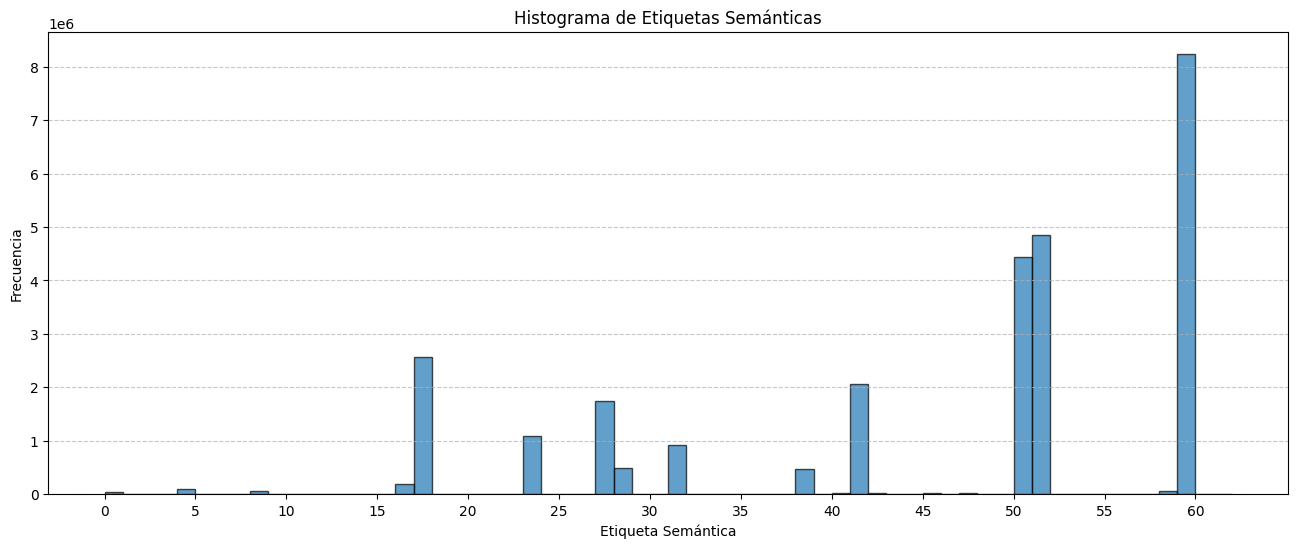

In [7]:
list_labels = []


for file in os.listdir(labels_path):

    # reading a .label file
    label = np.fromfile(os.path.join(labels_path, file), dtype=np.uint32)
    label = label.reshape((-1))

    # extract the semantic and instance label IDs
    sem_label = label & 0xFFFF  # semantic label in lower half

    list_labels.append(pd.DataFrame(sem_label, columns=["sem_label"]))

df_list_labels = pd.concat(list_labels)
    
# df_list_labels



plt.figure(figsize=(16, 6))
plt.hist(df_list_labels['sem_label'], 
         bins=np.arange(df_list_labels['sem_label'].min(), df_list_labels['sem_label'].max() + 2), 
         edgecolor='k', 
         alpha=0.7)

# Personalización del gráfico
plt.title("Histograma de Etiquetas Semánticas")
plt.xlabel("Etiqueta Semántica")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configurar las marcas del eje X en incrementos de 5
x_ticks = np.arange(df_list_labels['sem_label'].min(), df_list_labels['sem_label'].max() + 1, 5)
plt.xticks(x_ticks)

plt.show()

Ahora guardamos en un diccionario la **frecuencia** de cada clase semántica 

In [8]:
dict_freq_classes = df_list_labels['sem_label'].value_counts().sort_index().to_dict()

print(dict_freq_classes)

{0: 46510, 4: 106625, 6: 8574, 8: 53026, 11: 7371, 12: 3332, 13: 166, 14: 676, 16: 185234, 17: 2575001, 22: 654, 23: 1097123, 25: 483, 27: 1739569, 28: 485108, 29: 10271, 31: 916798, 32: 63, 33: 114, 34: 1570, 36: 959, 37: 1146, 38: 480450, 39: 1525, 40: 14054, 41: 2055614, 42: 17907, 45: 23167, 46: 2515, 47: 13568, 50: 4429725, 51: 4842732, 54: 46, 55: 584, 57: 5789, 58: 58862, 59: 8233179, 61: 301}


### Creación del Dataset de entrenamiento

Se leen los puntos de cada muestra y las etiquetas de cada muestra. `list_point_clouds` **es una lista** que almacena las 151 nubes de puntos, cada una es un dataframe con las columnas `x`, `y`, `z`, `remissions`

In [9]:
list_point_clouds = []

# Reading .bin files and adding to DF
for file in os.listdir(point_clouds_path):
    scan = np.fromfile(os.path.join(point_clouds_path, file), dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission

    df_point_cloud = pd.DataFrame(points, columns=["x","y","z"])
    df_point_cloud["remissions"] = remissions
    list_point_clouds.append(df_point_cloud)

# print(list_point_clouds)
del df_point_cloud